<font color = blue>
### 11.26.17 ADNIMERGE dataset exploration and visualization based on Rebecca's extracting ADNI2 from ADNI_merge and Hsiang's cleaning and imputation.
<br>
#### Recap of cleaning and imputation:
<ul>
<li> ADNI2 is extracted from ADNI_merge dataset as suggested by Rohan.</li>
<li> Linear regression / Logistic regression is used to impute continuous / categorical predictor.</li>
</ul>

<font color = blue>
#### Questions:
<ul>
  <li>There is no consensus on how to process -1/-4 entries. Are we going to treat -1/-4 as nan and impute them as well?
      <ul>
      <li>Columns containing -1: <ul>
                                  <li>RAVLT_forgetting_bl (1.2830%)</li>
                                  <li>RAVLT_learning (0.9658%)</li>
                                  <li>RAVLT_learning_bl (0.8217%)</li>
                                  <li>RAVLT_forgetting (0.7496%)</li>
                                 </ul>
      </li>
      <li>Columns containing -4: <ul>
                                  <li>RAVLT_forgetting (0.0288%)</li>
                                  <li>RAVLT_learning (0.0288%)</li>
                                  <li>RAVLT_forgetting_bl (0.0144%)</li>
                                 </ul>
      </li>
      </ul>
  </li>
  <li>There is no consensus on whether DX_bl or DX is the classification target.</li>
</ul>

<font color = blue>
#### Summarize finding below:
<ul>
<li> Using the imputed dataset, a decision tree with GridSearchCV gives training/testing score of 0.9466/0.9349.</li>
<li> Standardization doesn't affect result.</li>
<li> Using bootstrapping, 85 predictors out of 108 are found to be significant.</li>
<li> Scatter-plotted the most significant predictor "RAVLT_perc_forgetting_bl" and the second significant predictor "ADAS13_bl" with color indicating its class in y_train. Correlation can be roughly seen.</li>
</ul>

In [72]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV

from pprint import pprint 

from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection
from random import seed
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import RandomForestClassifier
from itertools import product
from collections import OrderedDict
from itertools import product

from sklearn import model_selection
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from __future__ import print_function # For Python 2 / 3 compatability
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [31]:
# load ADNIMERGE.csv
ADNI_merge = pd.read_csv('ADNIMERGE.csv')
ADNI_merge.head()

# select only the rows that correspond to ADN2
ADNI2 = ADNI_merge[ADNI_merge['COLPROT']=='ADNI2']
print("ADNI2 shape: ", ADNI2.shape)

# load ADNI2_mb_impute.csv
ADNI2_mb_impute = pd.read_csv('ADNI2_mb_impute.csv')
print("ADNI2_mb_impute shape: ", ADNI2_mb_impute.shape)

ADNI2_remove_all_missing = pd.read_json(path_or_buf='ADNI2_clean_remove_all_missing.json')
print("ADNI2_remove_all_missing shape: ", ADNI2_remove_all_missing.shape)

ADNI2 shape:  (6937, 94)
ADNI2_mb_impute shape:  (6937, 110)
ADNI2_remove_all_missing shape:  (6937, 19)


In [32]:
List_of_columns_containing_minus_four = \
["RAVLT_forgetting","RAVLT_learning", "RAVLT_forgetting_bl"]
List_of_columns_containing_minus_four = \
["RAVLT_forgetting_bl", "RAVLT_learning", "RAVLT_learning_bl", "RAVLT_forgetting"]

In [54]:
print(ADNI2["DX"].unique())
print("MCI" in ADNI2_mb_impute.columns)

['CN' 'Dementia' nan 'MCI']
False


In [60]:
# split and prepare X,y
np.random.seed(9001)
train_percentage = 0.75
msk = np.random.rand(len(ADNI2_mb_impute)) < train_percentage
data_train = ADNI2_mb_impute[msk]
data_test = ADNI2_mb_impute[~msk]

ADNI2_train = ADNI2[msk]
ADNI2_test  = ADNI2[~msk]

X_train = data_train.drop(["CN", "Dementia"], axis=1)
y_train = ADNI2_train['DX_bl']
X_test = data_test.drop(["CN", "Dementia"], axis=1)
y_test = ADNI2_test['DX_bl']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5246, 108)
(5246,)
(1691, 108)
(1691,)


In [168]:
#CV tree classifier
n_estimators =np.arange(1, 20)
param_grid = dict(max_depth=n_estimators)
gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=2)
gs.fit(X_train, y_train)
tree = gs.best_estimator_

print("Before standardization:")
print('Train accuracy: {}'.format(tree.score(X_train, y_train)))
print('Test accuracy: {}'.format(tree.score(X_test, y_test)))

Before standardization:
Train accuracy: 0.9466260007624857
Test accuracy: 0.934949733885275


In [68]:
# Standardization
continuous_predictors = ['AGE',
                  'FDG', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 
                  'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 
                  'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 
                  'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 
                  'EcogSPTotal', 'Ventricles', 'Hippocampus', 'WholeBrain', 
                  'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'CDRSB_bl', 'ADAS11_bl', 
                  'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 
                  'RAVLT_perc_forgetting_bl', 'FAQ_bl', 'Ventricles_bl', 
                  'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl',
                  'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl', 'EcogPtPlan_bl', 'EcogPtOrgan_bl', 
                  'EcogPtDivatt_bl', 'EcogPtTotal_bl', 'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 
                  'EcogSPPlan_bl', 'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl', 
                  'AV45_bl', 'Years_bl']

def standardize(df_train, df_test):
    df_train_std = df_train.copy()
    df_test_std = df_test.copy()
    for col in continuous_predictors:
        train_mean = df_train[col].mean()
        train_std  = df_train[col].std()
        df_train_std[col] = (df_train[col]- train_mean) / train_std
        df_test_std[col]  = (df_test[col] - train_mean) / train_std
    return df_train_std, df_test_std

X_train_std, X_test_std = standardize(X_train, X_test)

print(X_train_std.shape)
print(y_train.shape)
print(X_test_std.shape)
print(y_test.shape)

(5246, 108)
(5246,)
(1691, 108)
(1691,)


In [169]:
#CV tree classifier
n_estimators =np.arange(1, 20)
param_grid = dict(max_depth=n_estimators)
gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=2)
gs.fit(X_train_std, y_train)
tree = gs.best_estimator_

print("After standardization:")
print('Train accuracy: {}'.format(tree.score(X_train_std, y_train)))
print('Test accuracy: {}'.format(tree.score(X_test_std, y_test)))

After standardization:
Train accuracy: 0.9466260007624857
Test accuracy: 0.934949733885275


In [ ]:
# Bootstrapping to examine significance of various predictors

ITER = 100
CLASS_NUM = 0 # Examining significnace of predictors for which class
ci_boot = np.zeros((X_train.shape[1],100))

for i in range(ITER):
    # sample with replacement from X_train
    boot_rows = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    X_train_boot = X_train.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]

    # fit
    lr_boot = LogisticRegression(C=100000, fit_intercept=False)
    lr_boot.fit(X_train_boot, y_train_boot)
    ci_boot[:,i] = lr_boot.coef_[CLASS_NUM]
    
    print(str(i)+' ', end='')

In [170]:
ci_upper = np.percentile(ci_boot, 97.5, axis=1)
ci_lower = np.percentile(ci_boot, 2.5, axis=1)

sig_b_ct = 0
for i in range(len(ci_upper)):
    if ci_upper[i]<0 or ci_lower[i]>0:
        sig_b_ct += 1

print("Significant coefficents = %i / %i" % (sig_b_ct, ci_boot.shape[0]))

Significant coefficents = 85 / 108


In [115]:
c_sig = []
for idx, c in enumerate(ci_boot):
    c_upper = np.percentile(c, 97.5)
    c_lower = np.percentile(c, 2.5)
    if c_upper<0 or c_lower>0:
        c_sig.append( (X_train.columns[idx], c) )

c_sig_sorted = sorted(c_sig, key=lambda x: np.abs(np.mean(x[1])), reverse=True)

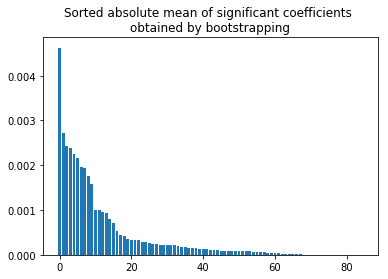

In [123]:
fig, ax = plt.subplots(1, 1)
ax.bar([i for i in range(len(c_sig_sorted))], [np.abs(np.mean(c[1])) for c in c_sig_sorted])
ax.set_title("Sorted absolute mean of significant coefficients \nobtained by bootstrapping")

In [125]:
print("Top 20 significant coefficients and their absolute mean:")
for i in range(20):
    print(c_sig_sorted[i][0], " / ", np.abs(np.mean(c_sig_sorted[i][1])))

Top 20 significant coefficients and their absolute mean:
RAVLT_perc_forgetting_bl  /  0.00462518446325
ADAS13_bl  /  0.00272666132255
ADAS13  /  0.00241995194476
RAVLT_immediate_bl  /  0.00237420677516
FAQ_bl  /  0.00224243584427
RAVLT_perc_forgetting  /  0.00215434621858
ADAS11_bl  /  0.00195333039407
RAVLT_immediate  /  0.00193492451348
ADAS11  /  0.00175076216154
FAQ  /  0.00157135110267
MMSE_bl  /  0.000994862009198
MOCA  /  0.000992705619579
MOCA_bl  /  0.000959130902684
MMSE  /  0.000927102945526
Entorhinal_bl  /  0.000800918378921
CDRSB_bl  /  0.000710591648226
Hippocampus_bl  /  0.00053346875273
CDRSB  /  0.000433355739066
RAVLT_learning_bl  /  0.000422031236242
RAVLT_learning  /  0.000344052179123


y_train unique values:  ['SMC' 'AD' 'EMCI' 'LMCI' 'CN']
Plotting the most significant predictor, color indicating its class in y_train:


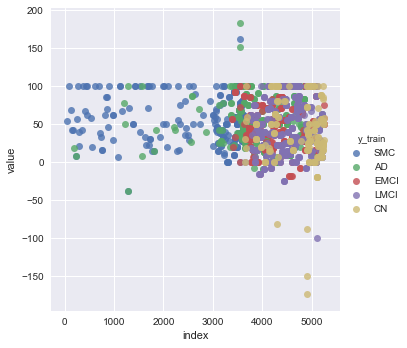

In [167]:
import seaborn as sns

print("y_train unique values: ", y_train.unique())

ind = [i for i in range(len(y_train))]
data = {"index":ind,\
        "value":X_train["RAVLT_perc_forgetting_bl"].values,\
        "y_train": y_train}
kmeans_df = pd.DataFrame(data, index = ind)
print("Plotting the most significant predictor, color indicating its class in y_train:")
lm = sns.lmplot(x="index",y="value", hue="y_train", data=kmeans_df, scatter=True, fit_reg=False)

Plotting the second significant predictor, color indicating its class in y_train:


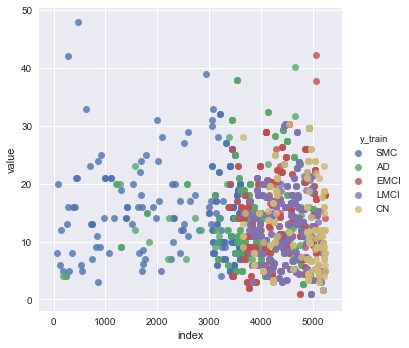

In [171]:
ind = [i for i in range(len(y_train))]
data = {"index":ind,\
        "value":X_train["ADAS13_bl"].values,\
        "y_train": y_train}
kmeans_df = pd.DataFrame(data, index = ind)
print("Plotting the second significant predictor, color indicating its class in y_train:")
lm = sns.lmplot(x="index",y="value", hue="y_train", data=kmeans_df, scatter=True, fit_reg=False)